## Importing required libraries for project

In [1]:
import sklearn.utils.validation
import sklearn.utils

# 1. Capture the original check_array function
_original_check_array = sklearn.utils.validation.check_array

# 2. Define a wrapper function to translate the arguments
def _compatible_check_array(*args, **kwargs):
    if 'force_all_finite' in kwargs:
        # Rename the old argument to the new one
        kwargs['ensure_all_finite'] = kwargs.pop('force_all_finite')
    return _original_check_array(*args, **kwargs)

# 3. Apply the patch to the locations where factor_analyzer looks for it
sklearn.utils.validation.check_array = _compatible_check_array
sklearn.utils.check_array = _compatible_check_array

In [2]:
# Install missing package for factor analysis
%pip install factor_analyzer

import pandas as pd
import numpy as np
import seaborn as sns
from factor_analyzer import FactorAnalyzer
import matplotlib.pyplot as plt
from factor_analyzer.factor_analyzer import calculate_kmo
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from factor_analyzer.factor_analyzer import calculate_bartlett_sphericity
import s3fs
import io
import warnings
warnings.filterwarnings('ignore')

Note: you may need to restart the kernel to use updated packages.


## Loading data set

In [3]:
MINIO_OPTS = {
    "key": "admin",
    "secret": "password123",
    "client_kwargs": {"endpoint_url": "http://localhost:9000"}
}
    
# 1. Load Merged Data from Gold
try:
    ds = pd.read_parquet("s3://gold/merged_data.parquet", storage_options=MINIO_OPTS)
except Exception as e:
    print(f"Error loading data: {e}")

In [4]:
ds

,traffic_id,date_time,city,area,vehicle_count,road_condition,avg_speed_kmh,congestion_level,accident_count,visibility_traffic,weather_id,season,temperature_c,humidity,rain_mm,weather_condition,wind_speed_kmh,visibility_weather,air_pressure_hpa
0,9001,2024-01-01 00:00:00,London,Camden,390.0,Snowy,78.737236,Low,0.0,10000.0,5001,Winter,-2.210000,0.604692,15.693069,Snow,43.600000,3924.875000,1010.730000
1,9002,2024-01-01 02:00:00,London,Camden,49.0,Dry,124.040482,Low,2.5,10000.0,5002,Winter,14.460000,80.000000,4.201908,Clear,78.820000,9857.000000,1004.810000
2,9003,2024-01-01 04:00:00,London,Chelsea,432.0,Snowy,48.830000,Low,2.5,10000.0,5003,Winter,4.250000,84.000000,0.000000,Snow,21.420000,9620.000000,996.090000
3,9004,2024-01-01 06:00:00,London,Islington,884.0,Dry,83.270000,Low,0.0,10000.0,5004,Winter,1.410000,74.000000,0.000000,Clear,54.420000,11148.000000,1007.390000
4,9005,2024-01-01 08:00:00,London,Greenwich,3382.0,Dry,89.618408,Low,0.0,10000.0,5005,Winter,7.510000,52.000000,0.000000,Clear,66.936188,11599.000000,999.580000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5245,13531,2025-12-01 12:00:00,London,Westminster,2100.0,Dry,33.070000,Medium,0.0,10000.0,9531,Winter,9.614634,62.000000,2.671853,Clear,127.840000,8453.000000,1022.760000
5246,13532,2025-12-01 14:00:00,London,Southwark,2060.0,Dry,103.249352,Low,2.5,10000.0,9532,Winter,-11.039801,29.000000,0.000000,Clear,52.210000,10410.000000,1023.470000
5247,13534,2025-12-01 18:00:00,London,Chelsea,4021.0,Snowy,3.000000,High,0.0,10000.0,9534,Winter,-3.110000,0.604692,0.000000,Snow,70.330000,10946.243164,1016.450000
5248,13902,2025-12-02 10:00:00,London,Islington,2054.0,Dry,27.350000,Medium,1.0,10000.0,9902,Winter,3.550000,69.000000,4.440000,Fog,29.760000,16285.875000,1015.670000


In [5]:
features = ["temperature_c","humidity","rain_mm","wind_speed_kmh","visibility_weather","air_pressure_hpa","vehicle_count","avg_speed_kmh","accident_count"]
df = ds[features].copy()
df

,temperature_c,humidity,rain_mm,wind_speed_kmh,visibility_weather,air_pressure_hpa,vehicle_count,avg_speed_kmh,accident_count
0,-2.210000,0.604692,15.693069,43.600000,3924.875000,1010.730000,390.0,78.737236,0.0
1,14.460000,80.000000,4.201908,78.820000,9857.000000,1004.810000,49.0,124.040482,2.5
2,4.250000,84.000000,0.000000,21.420000,9620.000000,996.090000,432.0,48.830000,2.5
3,1.410000,74.000000,0.000000,54.420000,11148.000000,1007.390000,884.0,83.270000,0.0
4,7.510000,52.000000,0.000000,66.936188,11599.000000,999.580000,3382.0,89.618408,0.0
...,...,...,...,...,...,...,...,...,...
5245,9.614634,62.000000,2.671853,127.840000,8453.000000,1022.760000,2100.0,33.070000,0.0
5246,-11.039801,29.000000,0.000000,52.210000,10410.000000,1023.470000,2060.0,103.249352,2.5
5247,-3.110000,0.604692,0.000000,70.330000,10946.243164,1016.450000,4021.0,3.000000,0.0
5248,3.550000,69.000000,4.440000,29.760000,16285.875000,1015.670000,2054.0,27.350000,1.0


# (1) Checking factor analysis assumtions:
## a) No outliers in the data set => Done ✅
## b) Data set size (number of rows) > Number of factors => Done ✅

# <hr style="height:3px; border:none; background:#4a90e2;">

## c) Checking whether there is perfect collinearity between feature or not

In [6]:
corr_matrix = df.corr()
perfect_corr_found = False
for i in range(len(corr_matrix.columns)):
    for j in range(i+1, len(corr_matrix.columns)):
        if abs(corr_matrix.iloc[i, j]) > 0.999:
            print(f"❌ PERFECT MULTI-COLLINEARITY FOUND:")
            print(f"   {corr_matrix.columns[i]} and {corr_matrix.columns[j]}")
            print(f"   Correlation: {corr_matrix.iloc[i, j]:.6f}")
            perfect_corr_found = True

if not perfect_corr_found:
    print("✓ No perfect multi-collinearity detected (all |r| < 0.999)")

✓ No perfect multi-collinearity detected (all |r| < 0.999)


In [7]:
# Check determinant of correlation matrix
corr_det = np.linalg.det(corr_matrix)
print(f"\nCorrelation matrix determinant: {corr_det:.10f}")
if corr_det > 0.00001:
    print("✓ Determinant > 0.00001: No perfect multi-collinearity")
else:
    print("⚠️  Low determinant: Possible multi-collinearity issues")


Correlation matrix determinant: 0.5298714644
✓ Determinant > 0.00001: No perfect multi-collinearity


## There is no perfect collinearity between features in the data set => Done ✅

In [8]:
# Calculate variances of all variables
variances = df.var()
variance_ratio = variances.max() / variances.min()

print(f"Variance ratio (max/min): {variance_ratio:.4f}")
if variance_ratio < 10:
    print("✓ Variance ratio < 10: Homoscedasticity likely acceptable")
elif variance_ratio < 50:
    print("⚠️  Moderate variance differences (ratio: 10-50)")
else:
    print("❌ Large variance differences (ratio ≥ 50) - Consider standardization")

Variance ratio (max/min): 12647752.0699
❌ Large variance differences (ratio ≥ 50) - Consider standardization


## Homoscedasticity is not satisfied between data set features ❌

# <hr style="height:3px; border:none; background:#4a90e2;">

## Standardizing features to achive Homoscedasticity

In [9]:
scaler = StandardScaler()

# Fit and transform the data
df_scaled_array = scaler.fit_transform(df)

# Convert the result back to a DataFrame, keeping the original column names
df_standardized = pd.DataFrame(df_scaled_array, columns=df.columns)

df_standardized.head()

,temperature_c,humidity,rain_mm,wind_speed_kmh,visibility_weather,air_pressure_hpa,vehicle_count,avg_speed_kmh,accident_count
0,-1.404360,-2.419748,1.472975,-0.209362,-1.819344,0.210119,-1.012801,0.785396,-0.591731
1,0.126305,0.730482,-0.083321,0.862115,-0.137736,-0.095620,-1.235333,2.147196,1.928621
2,-0.811193,0.889193,-0.652402,-0.884130,-0.204920,-0.545964,-0.985392,-0.113605,1.928621
3,-1.071966,0.492415,-0.652402,0.119808,0.228230,0.037625,-0.690421,0.921649,-0.591731
4,-0.511855,-0.380496,-0.652402,0.500581,0.356077,-0.365723,0.939746,1.112480,-0.591731


## Checking again for Homoscedasticity between data set features after standardizing the data set features

In [10]:
# Calculate variances of all variables
variances = df_standardized.var()
variance_ratio = variances.max() / variances.min()

print(f"Variance ratio (max/min): {variance_ratio:.4f}")
if variance_ratio < 10:
    print("✓ Variance ratio < 10: Homoscedasticity likely acceptable")
elif variance_ratio < 50:
    print("⚠️  Moderate variance differences (ratio: 10-50)")
else:
    print("❌ Large variance differences (ratio ≥ 50) - Consider standardization")

Variance ratio (max/min): 1.0000
✓ Variance ratio < 10: Homoscedasticity likely acceptable


## Homoscedasticity between data set features is satisfied now => Done ✅

# <hr style="height:3px; border:none; background:#4a90e2;">

## Now all factor analysis assumptions are satisfied ✅

# <hr style="height:3px; border:none; background:#4a90e2;">

# (2) Stating factor analysis test hypothesis

In [11]:
print("H₀ (Null Hypothesis):")
print("   The variables in the dataset are uncorrelated")
print("   (The correlation matrix is an identity matrix)")
print("\nHₐ (Alternative Hypothesis):")
print("   The variables are correlated enough")
print("   to be suitable for factor analysis")

H₀ (Null Hypothesis):
   The variables in the dataset are uncorrelated
   (The correlation matrix is an identity matrix)

Hₐ (Alternative Hypothesis):
   The variables are correlated enough
   to be suitable for factor analysis


# (3) Testing data set adequacy for factor analysis

# <hr style="height:3px; border:none; background:#4a90e2;">

## a) Using Barlett's test

In [12]:
chi_square, p_value = calculate_bartlett_sphericity(df_standardized)
print(f"Chi-square: {chi_square:.2f}")
print(f"p-value: {p_value:.10f}")

if p_value <= 0.05:
    print("✅ TEST SIGNIFICANT (p ≤ 0.05)")
    print("   → REJECT H₀: Variables are sufficiently correlated for FA")
else:
    print("❌ TEST NOT SIGNIFICANT (p > 0.05)")
    print("   → FAIL TO REJECT H₀: Variables may not be suitable for FA")

Chi-square: 3331.31
p-value: 0.0000000000
✅ TEST SIGNIFICANT (p ≤ 0.05)
   → REJECT H₀: Variables are sufficiently correlated for FA


## b) Using KMO (Kaiser-Meyer-Olkin) test

In [13]:
kmo_all, kmo_model = calculate_kmo(df_standardized)
print(f"KMO value (entire model): {kmo_model:.4f}")

if kmo_model >= 0.6:
    print("✅ KMO ≥ 0.6: Adequant for factor analysis ")
else:
    print("❌ KMO < 0.6: Not suitable for FA")

KMO value (entire model): 0.5323
❌ KMO < 0.6: Not suitable for FA


In [14]:
kmo_all

array([0.49877283, 0.53062392, 0.55039087, 0.69448477, 0.59621522,
       0.56914035, 0.49775838, 0.51063341, 0.63146918])

# We should stop and don't advance to Factor analysis implementation as although data set passed barlett test but failed to pass KMO test which means:
## 1.there is actually correlation between data set feature 
## 2. this correlation is not enough for factor analysis applying

# <hr style="height:3px; border:none; background:#4a90e2;">

# (4) Determining suitable number of factors for the factor analysis

# <hr style="height:3px; border:none; background:#4a90e2;">

## a) Using Kaiser criterion approach (statistical approach)

In [15]:
fa=FactorAnalyzer(9,rotation=None)
fa.fit(df_standardized)
ev,v=fa.get_eigenvalues()

In [16]:
number_of_factors_statistically=sum(ev > 1)

In [17]:
# Display eigenvalues
eigen_df = pd.DataFrame({
    'Factor': [f'F{i+1}' for i in range(len(ev))],
    'Eigenvalue': ev
})
print(eigen_df.to_string(index=False))
print(f"\nNumber of factors with eigenvalue > 1: {number_of_factors_statistically}")

# Initialize MinIO Connection
MINIO_OPTS = {
    "key": "admin",
    "secret": "password123",
    "client_kwargs": {"endpoint_url": "http://localhost:9000"}
}
fs = s3fs.S3FileSystem(**MINIO_OPTS)

# --- ADDED: Upload to MinIO Gold ---
csv_buffer = io.BytesIO()
eigen_df.to_csv(csv_buffer, index=False)

# Save as 'fa_eigenvalues.csv'
with fs.open("gold/factor_analysis/fa_eigenvalues.csv", "wb") as f:
    f.write(csv_buffer.getvalue())

print("-> Uploaded 'fa_eigenvalues.csv' to Gold Layer.")

Factor  Eigenvalue
    F1    1.694544
    F2    1.436931
    F3    1.146378
    F4    0.998654
    F5    0.969953
    F6    0.937844
    F7    0.766557
    F8    0.575373
    F9    0.473766

Number of factors with eigenvalue > 1: 3
-> Uploaded 'fa_eigenvalues.csv' to Gold Layer.


## b) Using scree plot approach (graphical approach)

-> Uploaded 'fa_scree_plot.png' to Gold Layer.


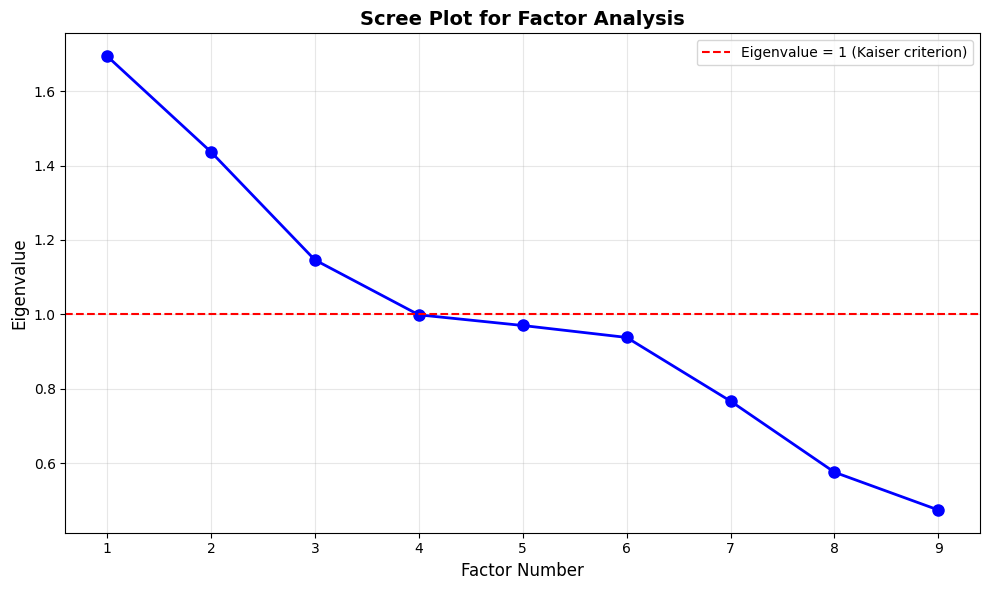

In [18]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(ev) + 1), ev, 'bo-', linewidth=2, markersize=8)
plt.axhline(y=1, color='r', linestyle='--', label='Eigenvalue = 1 (Kaiser criterion)')
plt.title('Scree Plot for Factor Analysis', fontsize=14, fontweight='bold')
plt.xlabel('Factor Number', fontsize=12)
plt.ylabel('Eigenvalue', fontsize=12)
plt.xticks(range(1, len(ev) + 1))
plt.grid(True, alpha=0.3)
plt.legend()
plt.tight_layout()
# plt.show()

# --- 2. ADDED: Upload to MinIO Gold ---
# Save figure to a buffer instead of showing immediately
img_buffer = io.BytesIO()
plt.savefig(img_buffer, format='png')
img_buffer.seek(0)

# Upload the buffer to MinIO
with fs.open("gold/factor_analysis/fa_scree_plot.png", "wb") as f:
    f.write(img_buffer.getvalue())

print("-> Uploaded 'fa_scree_plot.png' to Gold Layer.")

plt.show()

In [19]:
# Determine elbow point (simple method)
if len(ev) > 2:
    diffs = np.diff(ev)
    # Find where the drop in eigenvalues flattens
    elbow_point = None
    for i in range(1, len(diffs)):
        if diffs[i] < diffs[i-1] * 0.5:  # Significant drop reduction
            elbow_point = i + 2  # +2 because diff starts from comparison of 1st and 2nd
            break
    if elbow_point:
        print(f"Suggested number of factors from scree plot (elbow method): {elbow_point}")
        n_factors_graphical = elbow_point
    else:
        print("No clear elbow point detected in scree plot")
        number_of_factors_graphically = number_of_factors_statistically
else:
    number_of_factors_graphically = number_of_factors_statistically

Suggested number of factors from scree plot (elbow method): 3


## (5) Factor analysis implemenation

In [20]:
# Define rotations to use
rotations = ['varimax', 'promax', 'quartimax']
rotation_names = ['Varimax Rotation', 'Promax Rotation', 'Quartimax Rotation']

# Dictionary to store all results
all_results = {}

for rotation, rotation_name in zip(rotations, rotation_names):
    print(f"\n{'='*60}")
    print(f"{rotation_name.upper()}")
    print('='*60)
    
    # Apply factor analysis
    if rotation == 'promax':
        # Promax rotation often uses kappa=4 by default
        fa = FactorAnalyzer(n_factors=number_of_factors_statistically, rotation=rotation)
    else:
        fa = FactorAnalyzer(n_factors=number_of_factors_statistically, rotation=rotation)
    
    fa.fit(df)
    
    # Store results
    results = {
        'fa_object': fa,
        'loadings': fa.loadings_,
        'communalities': fa.get_communalities(),
        'factor_variance': fa.get_factor_variance()
    }
    all_results[rotation] = results
    
    # a) Factor Loadings Table
    print("\na) FACTOR LOADINGS TABLE:")
    print("-"*40)
    
    loadings_df = pd.DataFrame(
        fa.loadings_,
        index=df.columns,
        columns=[f'Factor{i+1}' for i in range(number_of_factors_statistically)]
    )
    
    # Format for better readability
    formatted_loadings = loadings_df.copy()
    for col in formatted_loadings.columns:
        formatted_loadings[col] = formatted_loadings[col].apply(lambda x: f'{x:.4f}')
    
    print(formatted_loadings)
    
    # Upload Loadings to MinIO
    csv_buffer_load = io.BytesIO()
    loadings_df.to_csv(csv_buffer_load) # Save real values, not formatted strings
    filename_load = f"gold/factor_analysis/fa_loadings_{rotation}.csv"
    with fs.open(filename_load, "wb") as f:
        f.write(csv_buffer_load.getvalue())
    print(f"-> Uploaded '{filename_load}'")

    # b) Communalities
    print("\n\nb) COMMUNALITIES:")
    print("-"*40)
    
    commun_df = pd.DataFrame({
        'Variable': df.columns,
        'Communality': fa.get_communalities()
    })
    
    # Calculate and display average communality
    avg_communality = np.mean(fa.get_communalities())
    
    print(commun_df.to_string(index=False))
    print(f"\nAverage communality: {avg_communality:.4f}")
    
    # Upload Communalities to MinIO
    csv_buffer_comm = io.BytesIO()
    commun_df.to_csv(csv_buffer_comm, index=False)
    filename_comm = f"gold/factor_analysis/fa_communalities_{rotation}.csv"
    with fs.open(filename_comm, "wb") as f:
        f.write(csv_buffer_comm.getvalue())
    print(f"-> Uploaded '{filename_comm}'")

    # c) Factor Variance
    print("\n\nc) FACTOR VARIANCE:")
    print("-"*40)
    
    variance_data = fa.get_factor_variance()
    var_df = pd.DataFrame({
        'Factor': [f'Factor{i+1}' for i in range(number_of_factors_statistically)],
        'SS Loadings': variance_data[0],
        'Proportion Variance': variance_data[1],
        'Cumulative Variance': variance_data[2]
    })
    
    print(var_df.to_string(index=False))
    
    total_variance = variance_data[2][-1] * 100
    print(f"\nTotal variance explained: {total_variance:.2f}%")

    # Upload Factor Variance to MinIO
    csv_buffer_var = io.BytesIO()
    var_df.to_csv(csv_buffer_var, index=False)
    filename_var = f"gold/factor_analysis/fa_variance_{rotation}.csv"
    with fs.open(filename_var, "wb") as f:
        f.write(csv_buffer_var.getvalue())
    print(f"-> Uploaded '{filename_var}'")


VARIMAX ROTATION

a) FACTOR LOADINGS TABLE:
----------------------------------------
                    Factor1  Factor2  Factor3
temperature_c       -0.0349  -0.2558   0.3407
humidity             0.0105   0.3313  -0.0013
rain_mm              0.0233   0.7725   0.3979
wind_speed_kmh       0.0100   0.0318   0.1142
visibility_weather  -0.0211  -0.3112  -0.1431
air_pressure_hpa    -0.0087  -0.1332  -0.4635
vehicle_count        0.9081  -0.0122  -0.0067
avg_speed_kmh       -0.5689  -0.1169  -0.0486
accident_count       0.0505   0.0837  -0.0155
-> Uploaded 'gold/factor_analysis/fa_loadings_varimax.csv'


b) COMMUNALITIES:
----------------------------------------
          Variable  Communality
     temperature_c     0.182709
          humidity     0.109899
           rain_mm     0.755677
    wind_speed_kmh     0.014154
visibility_weather     0.117764
  air_pressure_hpa     0.232602
     vehicle_count     0.824857
     avg_speed_kmh     0.339681
    accident_count     0.009787

Average commu

# Factor analysis results of VARIMAX rotation (Orthogonal rotation):
## a) Factor (1)
### i- Name: Traffic Density & Speed Factor
### ii- most 2 affecting features/variables: vehicle_count and avg_speed_kmh

## b) Factor (2):
### i- Name: Precipitation & Moisture Factor
### ii- most 2 affecting features/variables: humidity and rain_mm

## c) Factor (3):
### i- Name: Precipitation-Pressure Factor
### ii- most 2 affecting features/variables: air_pressure_hpa and rain_mm 

# <hr style="height:3px; border:none; background:#4a90e2;">

# Factor analysis results of PROMAX rotation (Oblique rotation):
## a) Factor (1)
### i- Name: Traffic Density & Speed Factor
### ii- most 2 affecting features/variables: vehicle_count and avg_speed_kmh

## b) Factor (2):
### i- Name: Precipitation & Moisture Factor
### ii- most 2 affecting features/variables: humidity and rain_mm

## c) Factor (3):
### i- Name: Temperature-Pressure Gradient
### ii- most 2 affecting features/variables: air_pressure_hpa and temperature_c  

# <hr style="height:3px; border:none; background:#4a90e2;">

# Factor analysis results of QUARTIMAX rotation (Orthogonal rotation):
## a) Factor (1)
### i- Name: Traffic Density & Speed Factor
### ii- most 2 affecting features/variables: vehicle_count and avg_speed_kmh

## b) Factor (2):
### i- Name: Low-Visibility Rain Factor
### ii- most 2 affecting features/variables: visibility_weather and rain_mm

## c) Factor (3):
### i- Name: Temperature-Pressure Gradient Factor
### ii- most 2 affecting features/variables: air_pressure_hpa and temperature_c 